In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # matplotlib = zakladna kniznica na vytvaranie grafov
import seaborn as sns 
import json
from scipy import stats as st
%matplotlib inline 
sns.set()

In [2]:
personal = pd.read_csv("data\personal_train.csv")

In [18]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 6 columns):
Unnamed: 0       3933 non-null int64
name             3933 non-null object
address          3933 non-null object
age              3933 non-null int64
sex              3933 non-null object
date_of_birth    3933 non-null object
dtypes: int64(2), object(4)
memory usage: 184.5+ KB


# Opis atributov
* Unnamed: 0 - jedna sa o integer hodnotu reprezentujucu index zaznamu
* name - 
* address - 
* age - integerova hodnota reprezentujuca vek subjektu
* sex - 
* date_of_birth - datum narodenia subjektu

In [19]:
personal.describe()

,Unnamed: 0,age
count,3933.000000,3933.000000
mean,1966.000000,51.816934
std,1135.503633,11.814803
min,0.000000,-1.000000
25%,983.000000,44.000000
50%,1966.000000,52.000000
75%,2949.000000,60.000000
max,3932.000000,113.000000


# TODO - outliers, ...

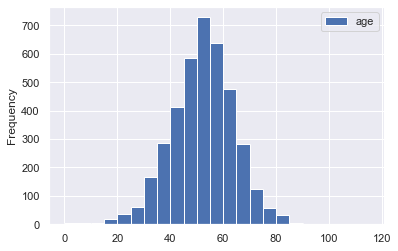

In [31]:
personal.age.plot(kind='hist', bins=[0,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115] , legend=True)

In [56]:
#TODO: graf rozdelenia pohlavi subjekov

Na histogramoch mozno vidiet, ze prevazna vacsina subjektov sa nachadza vo vekovom rozpati od 40 - 70 rokov, pricom najviac je zastupcov vo veku okolo 50 rokov.

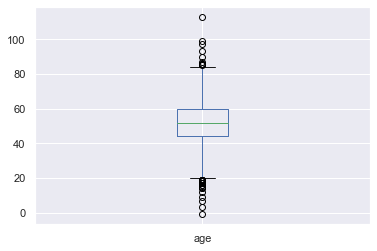

In [55]:
personal.age.plot(kind='box')

Pri veku mozme na boxplote vidiet, ze sa v datasete nachadzaju aj hodnoty veku -1 a 110+. Pri hodnote < 0 si mozeme byt isty, ze sa jedna o chybu a tento zaznam pravdepodobne pouzivat v analyze nebudeme. Hodnota 113 je sice velmi vychylena od zvysku, no stale sa moze jednat o korektnu hodnotu. 

In [5]:
personal

,Unnamed: 0,name,address,age,sex,date_of_birth
0,0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",54,Male,17/06/1965
1,1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",51,Female,1967-12-19
2,2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",65,Female,1954-06-27
3,3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",36,Male,1983-03-29
4,4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",30,Male,1988-11-29
...,...,...,...,...,...,...
3928,3928,Clair Pinkleton,"8582 Lee Roads\r\nCostaburgh, SC 21897",61,Female,1957-11-18 00 00 00
3929,3929,William Pope,68430 Erik Terrace Suite 279\r\nPort Adamborou...,51,Female,1968-08-22 00 00 00
3930,3930,Jared Kinsey,Unit 8416 Box 3801\r\nDPO AE 31166,50,Female,1969-06-27
3931,3931,Frederick Lawley,"34420 Brian Stream\r\nLake Michaeltown, MS 01832",64,Male,1954-12-04


# Mozne chyby + navrh riesenia
V csv personal sa nachadzaju osobne udaje o jednotlivych ludoch, t.j konkretne ich meno, adresa, vek, pohlave a datum narodenia
Mozme vidiet, ze mame nekonzistne zapisane datumy narodeni - raz vo formate D/M/Y, inokedy Y-M-D. V adresach sa nachadzaju znaky /r/n, ktore oddeluju jednotlive casti adries (ulice, mesto, atd...). V datasete personal_train mame dokopy 3933 zaznamov, pricom kazdy ma 6 atributov. Jeden z tychto atributov je poradove cislo zaznamu. Predpokladame, ze tento atribut realne potrebovat pri nasom zadani nebudeme, cize bude vhodne ho z datasetu odstranit. Hodnota veku v jednom zazname nadobuda hodnotu -1. Tento zaznam bude pravdepodobne potrebne odstranit.



In [6]:
#personal = personal.drop('Unnamed: 0', axis = 1) 

In [7]:
other = pd.read_csv("data\other_train.csv")

In [78]:
other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 27 columns):
Unnamed: 0          3983 non-null int64
name                3983 non-null object
address             3983 non-null object
kurtosis_oxygen     3969 non-null float64
occupation          3970 non-null object
marital-status      3967 non-null object
pregnant            3968 non-null object
education-num       3572 non-null float64
relationship        3969 non-null object
std_oxygen          3968 non-null float64
capital-gain        3969 non-null float64
skewness_oxygen     3964 non-null float64
education           3971 non-null object
fnlwgt              3974 non-null float64
class               3972 non-null float64
income              3971 non-null object
medical_info        3966 non-null object
native-country      3966 non-null object
capital-loss        3966 non-null float64
mean_oxygen         3972 non-null float64
hours-per-week      3967 non-null float64
race                397

# Opis atributov
* Unnamed: 0 - integerova hodnota obsahujuca index zaznamu
* name - krstne meno + priezvisko subjektu
* address - adresa subjektu
* kurtosis_oxygen - 
* occupation - obsahuje ?
* marital-status - rodinny stav
* pregnant - 
* education-num -   
* relationship - 
* std_oxygen - 
* capital-gain - 
* skewness_oxygen - 
* education -  
* fnlwgt -   
* class - hodnoty 0 1, reprezentuju ci ma subjekt cukrovku alebo nie (jedna sa o predikovanu hodnotu)
* income - rocny prijem subjektu 
* medical_info - atribut obsahujuci dalsie 4 atributy - mean_glucose, std_glucose, kurtosis_glucose a skewness_glucose. Bude ho potrebne rozdelit ako 4 samostatne atributy
* native-country - rodna krajina
* capital-loss - 
* mean_oxygen - 
* hours-per-week - 
* race -  rasa subjektu
* workclass - vykytuju sa hodnoty NaN a ???

In [79]:
other.describe()

,Unnamed: 0,kurtosis_oxygen,education-num,std_oxygen,capital-gain,skewness_oxygen,fnlwgt,class,capital-loss,mean_oxygen,hours-per-week
count,3983.00000,3969.000000,3572.000000,3968.000000,3969.000000,3964.000000,3974.000000,3972.000000,3966.000000,3972.000000,3967.000000
mean,1991.00000,7.423042,13.064110,31.158976,1118.833207,91.795908,190944.202063,0.255287,87.882753,18.504313,40.733552
std,1149.93739,4.846216,331.930108,22.265708,7522.515940,110.770563,103909.567546,0.436077,401.609490,34.837091,12.383999
min,0.00000,-2.597872,-1600.000000,7.370432,0.000000,-1.976976,14878.000000,0.000000,0.000000,0.213211,1.000000
25%,995.50000,3.637833,9.000000,15.064858,0.000000,12.966818,119457.750000,0.000000,0.000000,2.069189,40.000000
50%,1991.00000,7.781618,10.000000,20.579902,0.000000,68.623477,179434.500000,0.000000,0.000000,3.234532,40.000000
75%,2986.50000,10.259075,13.000000,43.229414,0.000000,126.894595,237933.000000,1.000000,0.000000,12.619983,45.000000
max,3982.00000,34.539844,1600.000000,110.642211,99999.000000,1191.000837,972354.000000,1.000000,3900.000000,217.371238,99.000000


In [114]:
#atribut medical info obsahuje hodnoty glukozy, ktore budu pravdepodobne klucove pri identifikacii cukrovky. Preto je potrebne
#tieto hodnoty reprezentovat ako samostatne atributy, cize je potrebne vytvorit nove stlpce v dataframe
other[['mean_glucose','std_glucose', 'kurtosis_glucose','skewness_glucose']] = other.medical_info.apply(lambda x: pd.Series(str(x).split(","))) 
other['mean_glucose'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+',value=r'')
other['std_glucose'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+', value=r'')
other['kurtosis_glucose'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+', value=r'')
other['skewness_glucose'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+', value=r'')
other = other.drop('medical_info', axis = 1)

V tejto casti kodu sme rozdelili atribut medical_info na 4 stlpce, aby sa nam s ciselnymi udajmi lepsie pracovalo. Vyuzili sme na tom najprv split, nasledne sme prostrednictvom regexu odstranili vsetky nenumericke znaky (okrem .)

In [115]:
other

,Unnamed: 0,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,...,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
0,0,James Wilhoit,"656 Anderson Road\r\nWest Christopherborough, ...",0.253562,Other-service,Never-married,f,1000.0,Own-child,75.716494,...,United-States,0.0,111.122910,40.0,White,Private,36.46875,39.27287102,3.736450963,14.914644699999998
1,1,Carey Trowbridge,"581 Amanda Turnpike Suite 551\r\nNew April, CT...",9.595103,Transport-moving,Never-married,f,13.0,Not-in-family,19.598770,...,United-States,0.0,2.153846,30.0,White,Private,101.0078125,41.5616064,0.247110802,0.527799075
2,2,Johnathon Maier,"83956 Rivera Fall\r\nAliciastad, VA 57310",5.835402,Prof-specialty,Divorced,f,10.0,Not-in-family,23.907751,...,United-States,0.0,4.820234,48.0,White,federal-gov,134.1328125,46.1719563,0.008403385,0.009397683
3,3,Larry Hawkins,"865 Stephanie Overpass\r\nHillbury, TN 13782",2.105287,Craft-repair,Married-civ-spouse,f,9.0,Husband,53.796010,...,United-States,0.0,28.642140,40.0,White,NaN,22.5,31.25374978,5.482057061,32.58985477
4,4,Oscar Driscoll,"848 Bautista Loaf Apt. 958\r\nMatthewtown, VA ...",12.012792,Prof-specialty,Married-civ-spouse,f,-1400.0,Husband,12.071025,...,United-States,1887.0,1.752508,40.0,White,Private,119.1328125,52.61466215,0.223922309,0.228760359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,3978,Benton Ybarra,"4817 Daniel Bridge Apt. 186\r\nChristineside, ...",11.959503,Sales,Married-civ-spouse,f,10.0,Husband,15.414254,...,United-States,0.0,1.483278,40.0,White,??,106.84375,41.6078113,0.393022617,1.154649341
3979,3979,Michael Colquitt,"94354 Thomas Extensions\r\nLake Douglasbury, M...",9.249480,Prof-specialty,Married-civ-spouse,f,1600.0,Husband,16.476213,...,United-States,1902.0,2.488294,40.0,White,State-gov,97.8671875,47.40852559,0.54364148,0.4061434370000001
3980,3980,James Pearl,"19716 Owens Port\r\nHensleyland, ME 35990",11.232226,Other-service,Divorced,f,9.0,Unmarried,12.260234,...,United-States,0.0,1.898829,40.0,White,Private,123.9375,38.86691033,0.262159929,0.717384881
3981,3981,Armand Mccoach,"8917 Evans Ferry\r\nLake Paul, SD 93388",8.392543,Protective-serv,Married-civ-spouse,f,9.0,Husband,15.339597,...,United-States,0.0,2.771739,48.0,White,State-gov,134.6953125,40.10349085,0.005275772,0.4926168


In [93]:
other.corr()["std_oxygen"]

Unnamed: 0        -0.012681
kurtosis_oxygen   -0.843469
education-num      0.002708
std_oxygen         1.000000
capital-gain       0.010195
skewness_oxygen   -0.605023
fnlwgt             0.002170
class              0.650266
capital-loss      -0.008789
mean_oxygen        0.802131
hours-per-week     0.024808
Name: std_oxygen, dtype: float64

In [94]:
other.corr()["class"]

Unnamed: 0        -0.002816
kurtosis_oxygen   -0.555643
education-num     -0.004584
std_oxygen         0.650266
capital-gain      -0.008443
skewness_oxygen   -0.385221
fnlwgt            -0.017244
class              1.000000
capital-loss      -0.006092
mean_oxygen        0.518284
hours-per-week     0.015091
Name: class, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022C69E0AE80>,
      dtype=object)

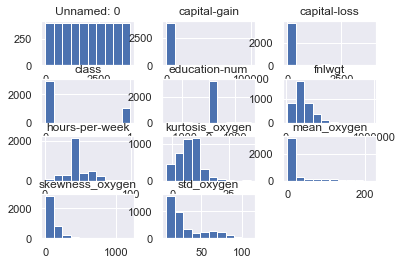

In [58]:
other.hist()

class
0.0    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
1.0    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
dtype: object

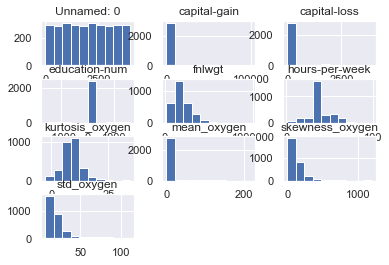

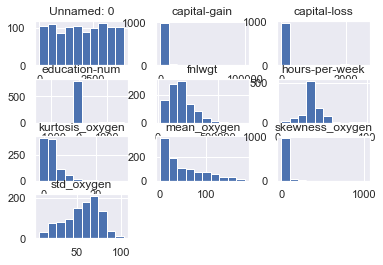

In [47]:
other.groupby('class').hist()

In [41]:
other = other.drop('Unnamed: 0', axis = 1) #opat sa mozme zbavit stlpca unnamed

In [ ]:
#data = pd.merge(personal, other,  how='left', left_on=['name','address'], right_on = ['name','address'])
#spojime oba dataframy do jedneho, pricom spolocne budu mat meno a adresu 
#data